In [1]:
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Datasets

In [3]:
x_train_cell_lines = pd.read_csv('../data/splits/train/x_train_cell_lines.csv', index_col=0)
x_train_drugs = pd.read_csv('../data/splits/train/x_train_drugs.csv', index_col=0)
y_train = pd.read_csv('../data/splits/train/y_train.csv', index_col=0)

x_test_cell_lines = pd.read_csv('../data/splits/test/x_test_cell_lines.csv', index_col=0)
x_test_drugs = pd.read_csv('../data/splits/test/x_test_drugs.csv', index_col=0)
y_test = pd.read_csv('../data/splits/test/y_test.csv', index_col=0)

x_val_cell_lines = pd.read_csv('../data/splits/val/x_val_cell_lines.csv', index_col=0)
x_val_drugs = pd.read_csv('../data/splits/val/x_val_drugs.csv', index_col=0)
y_val = pd.read_csv('../data/splits/val/y_val.csv', index_col=0)

In [4]:
x_test_drugs

,Drug
Picolinici-acid_VCaP,C1=CC=NC(=C1)C(=O)O
GSK2606414_SK-MM-2,CN1C=C(C2=C(N=CN=C21)N)C3=CC4=C(C=C3)N(CC4)C(=...
PLX-4720_SK-MEL-5,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...
Wee1 Inhibitor_NCI-H2369,C1=CC=C(C(=C1)C2=CC3=C(C4=C(N3)C=CC(=C4)O)C5=C...
Ipatasertib_CAPAN-1,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...
...,...
Sorafenib_MSTO-211H,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...
LJI308_SNU-C5,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
Afuresertib_OS-RC-2,CN1C(=C(C=N1)Cl)C2=C(SC(=C2)C(=O)N[C@@H](CC3=C...
MK-1775_SK-OV-3,CC(C)(C1=NC(=CC=C1)N2C3=NC(=NC=C3C(=O)N2CC=C)N...


In [5]:
x_train_cell_lines

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Dabrafenib_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,3.964336,4.023004,5.336447,6.466790,2.940953,3.332759,3.889705,7.408880,3.686703,2.593133
Lapatinib_TGW,4.086446,6.715755,3.152207,2.977787,11.495806,2.832806,5.748287,2.788454,3.656858,6.440322,...,4.428327,5.174020,7.852960,7.595099,3.038144,3.323596,2.739460,8.336177,3.337451,2.441808
Ruxolitinib_GCT,8.272114,5.417548,3.558538,3.053982,11.082245,2.823397,6.046880,4.953580,5.376569,5.403302,...,4.057561,2.942980,5.114811,6.261316,3.013983,3.076459,3.841630,8.332464,3.155997,2.544252
MN-64_EW-24,3.324724,4.391741,3.439392,6.849185,11.444114,3.069665,5.608626,2.964643,4.407107,6.767137,...,4.848096,4.416856,6.666332,6.872747,3.023575,3.449833,3.458194,9.104475,3.925635,2.662439
Sapitinib_NCI-H1869,7.296754,8.546812,3.664518,3.362914,10.627687,3.029736,4.349724,3.369286,4.738751,5.501484,...,3.986183,3.943430,5.563829,5.932634,2.925860,3.530848,4.134750,8.301205,3.474793,2.756528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,7.851452,6.143533,3.774689,2.937680,11.339133,3.043644,4.580882,5.089882,3.330522,5.595879,...,4.793499,4.738768,6.726044,5.808590,2.832737,3.678759,4.410979,8.231673,3.377068,3.009807
I-BRD9_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,3.964336,4.023004,5.336447,6.466790,2.940953,3.332759,3.889705,7.408880,3.686703,2.593133
Olaparib_RERF-GC-1B,7.103327,6.057814,3.285193,2.881877,11.527119,2.978740,5.526652,3.157037,4.615804,6.645393,...,5.960230,6.854925,6.428696,6.726985,2.792515,3.375117,3.350753,8.907326,3.454210,2.510775
Crizotinib_HCC2218,7.205591,5.356177,3.342622,2.919920,11.388315,3.095454,4.328444,3.060736,3.731668,5.786437,...,4.061743,3.632399,6.157377,6.432589,3.374558,3.612480,3.698259,8.743277,3.809671,2.523288


In [6]:
x_train_drugs

,Drug
Dabrafenib_SW1710,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...
Lapatinib_TGW,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...
Ruxolitinib_GCT,C1CCC(C1)[C@@H](CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
MN-64_EW-24,CC(C)C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2
Sapitinib_NCI-H1869,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...
...,...
PFI3_SW1463,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...
I-BRD9_SW1710,CCN1C=C(C2=C(C1=O)C=C(S2)C(=NC3CCS(=O)(=O)CC3)...
Olaparib_RERF-GC-1B,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...
Crizotinib_HCC2218,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...


### Featurizer

In [7]:
from featurizers import GraphFeaturizer

featurizer_train = GraphFeaturizer()
node_features_train, adjacency_matrix_train = featurizer_train.featurize_df(x_train_drugs, 'Drug')

featurizer_val = GraphFeaturizer()
node_features_val, adjacency_matrix_val = featurizer_val.featurize_df(x_val_drugs, 'Drug')

featurizer_test = GraphFeaturizer()
node_features_test, adjacency_matrix_test = featurizer_test.featurize_df(x_test_drugs, 'Drug')


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### Drug GAT model

In [8]:
from models import DrugGATModel


# Example usage

model = DrugGATModel(expr_dim=x_train_cell_lines.shape[1], expr_hlayers_sizes='[156, 156]', drug_gat_layers='[125, 75]',predictor_hlayers_sizes='[125]', hidden_dropout=0.3, optimizer='Adam', learn_rate=0.0001)
print(model.summary())
model.train(x_train_cell_lines, node_features_train, adjacency_matrix_train, y_train, epochs=100, batch_size=64)

val_loss, val_mae = model.evaluate(x_val_cell_lines, node_features_val, adjacency_matrix_val, y_val)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines, node_features_test, adjacency_matrix_test)
print(predictions)

f:\Anaconda\envs\drugsense\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 156)          326040      ['cell_line_input[0][0]']        
                                                                                                  
 activation (Activation)        (None, 156)          0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 156)         624         ['activation[0][0]']             
 alization)                                                                                   

f:\Anaconda\envs\drugsense\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
691/691 [==============================] - 25s 32ms/step - loss: 10.9323 - mae: 2.8125 - val_loss: 7.5902 - val_mae: 2.3240
Epoch 2/100
  3/691 [..............................] - ETA: 20s - loss: 8.5007 - mae: 2.4456

f:\Anaconda\envs\drugsense\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


691/691 [==============================] - 22s 31ms/step - loss: 6.6951 - mae: 2.1083 - val_loss: 4.4227 - val_mae: 1.6218
Epoch 3/100
691/691 [==============================] - 20s 30ms/step - loss: 5.0587 - mae: 1.7589 - val_loss: 4.0941 - val_mae: 1.5082
Epoch 4/100
691/691 [==============================] - 20s 29ms/step - loss: 4.4576 - mae: 1.6288 - val_loss: 4.1670 - val_mae: 1.6499
Epoch 5/100
691/691 [==============================] - 20s 30ms/step - loss: 4.1444 - mae: 1.5730 - val_loss: 3.4565 - val_mae: 1.4288
Epoch 6/100
691/691 [==============================] - 21s 31ms/step - loss: 3.7926 - mae: 1.5058 - val_loss: 3.0502 - val_mae: 1.3001
Epoch 7/100
691/691 [==============================] - 21s 31ms/step - loss: 3.4356 - mae: 1.4398 - val_loss: 2.7573 - val_mae: 1.2426
Epoch 8/100
691/691 [==============================] - 21s 30ms/step - loss: 3.3657 - mae: 1.4197 - val_loss: 2.9566 - val_mae: 1.2787
Epoch 9/100
691/691 [==============================] - 21s 30ms/ste

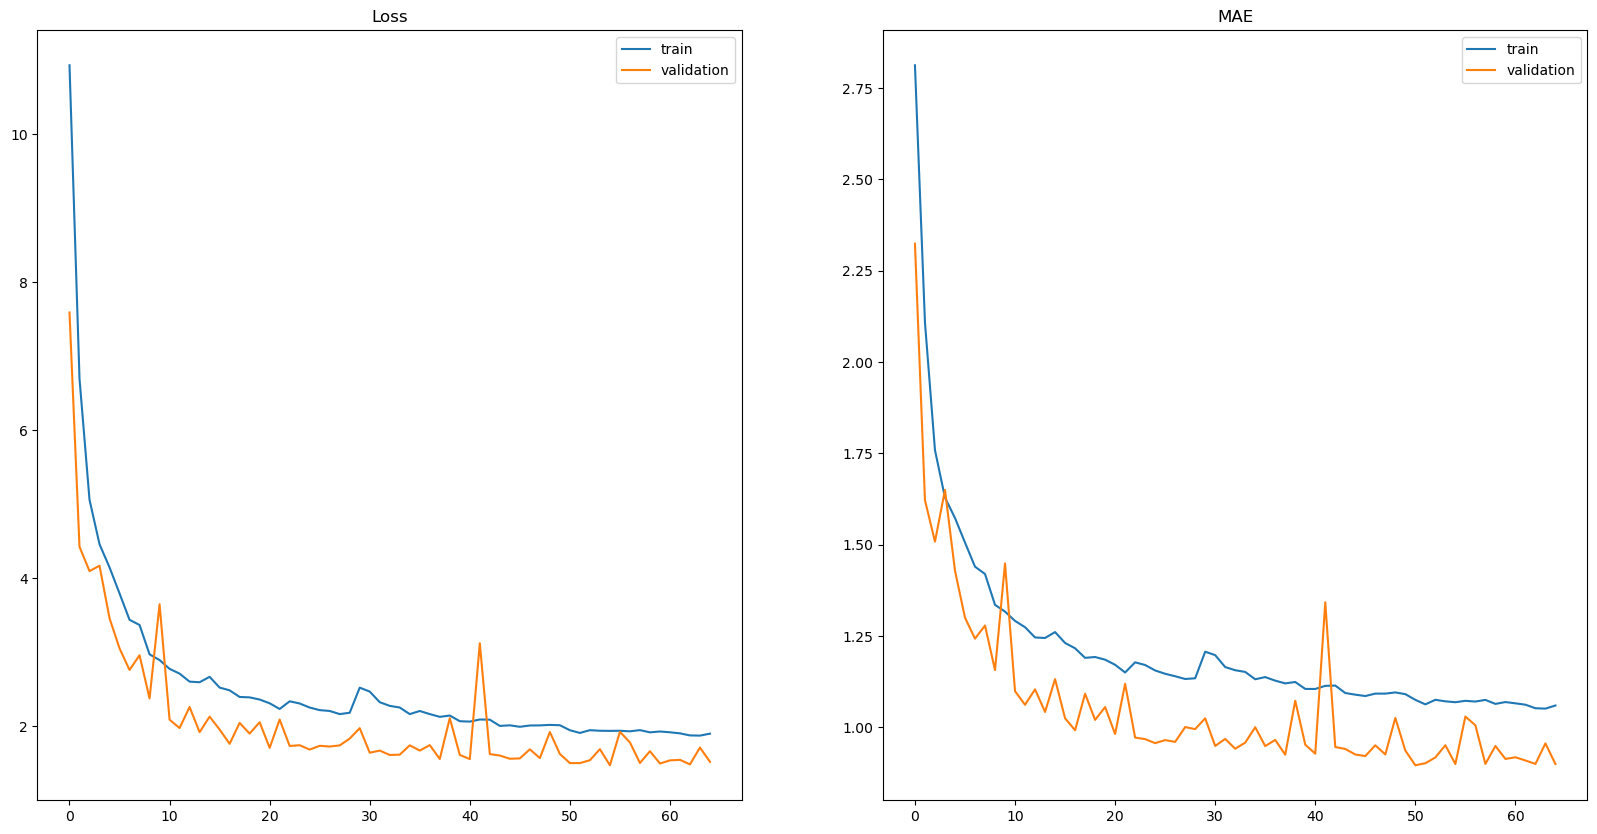

In [9]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()





In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print('GAT model')
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2: ', r2_score(y_test, predictions))

GAT model
MAE:  0.8955245556997675
MSE:  1.4261088834921782
RMSE:  1.1941980084944783
R2:  0.8120744093695402
